In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# magic function, graphic appears below cell and is stored in notebook
%matplotlib inline 
from matplotlib import cm
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier

In [52]:
def load_dataset(path):
    return pd.read_csv(path, header=0)

def correlation(dataset):
    fig = plt.figure(figsize=(8, 5))
    corr = dataset.corr()

    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, fontsize=10, rotation=45, ha='left')
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=10)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()

    
def split_dataset(dataset, labels_colname, test_size=0.25):
    global seed
    # Create features and labels 
    features = dataset.drop([labels_colname], axis=1)
    labels = dataset[labels_colname]
    
    # Create training and test set 
    from sklearn.model_selection import train_test_split
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=test_size, random_state=seed)
    
    return features_train, features_test, labels_train, labels_test


def scaling(features_train, features_test, scaler="s"):
    # Minmax Normalisation
    if scaler == "m":
        from sklearn.preprocessing import MinMaxScaler 
        minMaxScaler = MinMaxScaler()
        features_train_scaled = minMaxScaler.fit_transform(features_train) 
        features_test_scaled = minMaxScaler.transform(features_test)
    
    # Standardisation
    elif scaler == "s":
        from sklearn.preprocessing import StandardScaler
        standardScaler = StandardScaler()
        features_train_scaled = standardScaler.fit_transform(features_train) 
        features_test_scaled = standardScaler.transform(features_test)
   
    return features_train_scaled, features_test_scaled
    
def imputation(dataset, columns, miss_value, imputer="median"):
    from sklearn.impute import SimpleImputer
    
    # imputation with median strategy
    if imputer == "median":
        im = SimpleImputer(missing_values = miss_value, strategy = 'median')
        dataset_imputed = im.fit_transform(dataset[columns]) # ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
        dataset[columns] = dataset_imputed
    
    # imputation with mean strategy
    elif imputer == "mean":
        im = SimpleImputer(missing_values = miss_value, strategy = 'mean')
        dataset_imputed = im.fit_transform(dataset[columns])
        dataset[columns] = dataset_imputed
    
    return dataset

def rebalance(features_train,labels_train, labels_colname, resampling="up"):
    global seed
    df = pd.concat([features_train,labels_train],axis=1)
    # Separate majority and minority classes
    df_majority = df[df[labels_colname]==0] 
    df_minority = df[df[labels_colname]==1]
    major_samples = len(df_majority)
    minor_samples = len(df_minority)
    from sklearn.utils import resample
    
    if resampling == "up":
        # Upsample samples with replacement for minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True, # sample with replacement
                                         n_samples=major_samples, # to match majority class
                                         random_state=seed) # reproducible results
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])
        # re-preparing the training sets
        features_train = df_upsampled.drop([labels_colname], axis=1)
        labels_train = df_upsampled[[labels_colname]]
    
    elif resampling == "down":
        # Upsample samples without replacement for minority class
        df_majority_downsampled = resample(df_majority,
                                           replace=False, # sample without replacement
                                           n_samples=minor_samples, # to match minority class
                                           random_state=seed) # reproducible results
        df_downsampled = pd.concat([df_majority_downsampled, df_minority])
        # re-preparing the training sets
        features_train = df_downsampled.drop([labels_colname], axis=1)
        labels_train = df_downsampled[[labels_colname]]
    
    return features_train,labels_train


def display_metrics(labels_test, pred):
    #Check accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(labels_test, pred)
    print('Accuracy: {:.2f}'.format(accuracy))
    
    #Check precision
    from sklearn.metrics import precision_score
    precision = precision_score(labels_test, pred)
    print ('Precision: {:.2f}'.format(precision))

    # Check recall
    from sklearn.metrics import recall_score
    recall = recall_score(labels_test, pred)
    print ('Recall: {:.2f}'.format(recall))

    # Check F1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(labels_test, pred)
    print ('F1 score: {:.2f}'.format(f1))

    # Check with AUROC
    from sklearn.metrics import roc_auc_score
    auroc = roc_auc_score(labels_test, pred)
    print ('AUROC score: {:.2f}'.format(auroc))
    return accuracy, precision, recall, f1, auroc


def plot_roc_curve(labels_test, pred):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(labels_test, pred)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def models_boxplot(features_train, labels_train, models, scoring):
    results = []
    names = []
    
    from sklearn import model_selection
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, features_train,labels_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle(f'Algorithm Comparison\n(score={scoring})')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

#### Data exploration

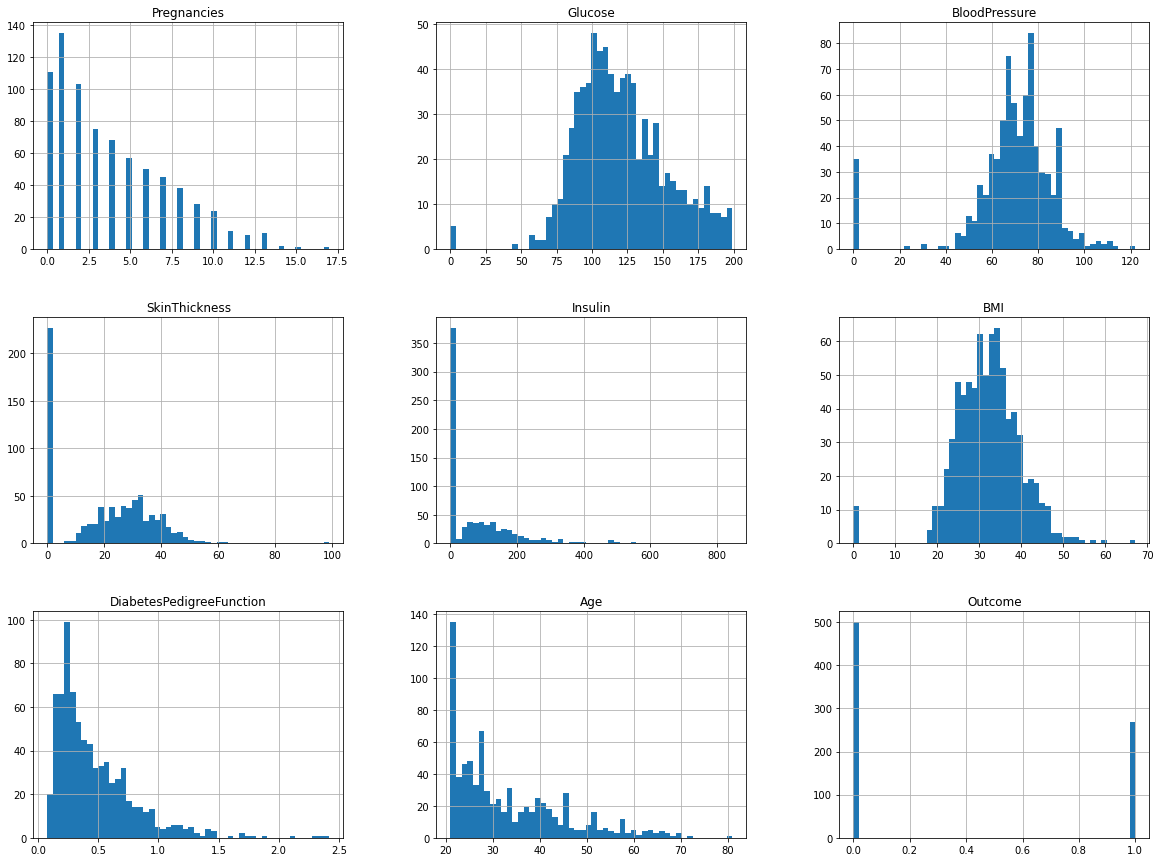

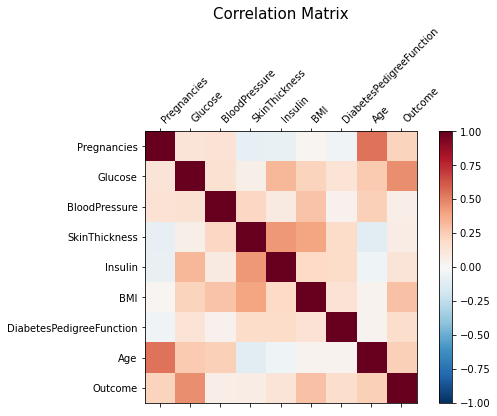

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [42]:
seed = 123
path = "diabetes.csv"

dataset = load_dataset(path)
dataset.hist(bins=50, figsize = (20,15))
correlation(dataset)
plt.show()
dataset.head()

KNN: 0.718875 (0.052301)
SVM: 0.746733 (0.042838)
LR: 0.760678 (0.043865)
DT: 0.668391 (0.075961)
RM: 0.752027 (0.053007)


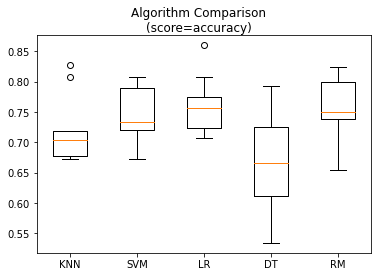

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
models_boxplot(features_train,labels_train, 
               models=[('KNN', KNeighborsClassifier()),
                       ('SVM', SVC()),
                       ('LR', LogisticRegression()), 
                       ('DT', DecisionTreeClassifier()),
                       ('RM', RandomForestClassifier())], 
               scoring='accuracy')

#### Data preprocessing

In [43]:
# columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# dataset = imputation(dataset, columns, 0, imputer="median")
features_train, features_test, labels_train, labels_test = split_dataset(dataset, 'Outcome', test_size=0.25)
# features_train,labels_train = rebalance(features_train ,labels_train, 'Outcome', resampling="up")
# features_train_scaled, features_test_scaled = scaling(features_train, features_test, scaler="s")

#### A very raw model

In [47]:
classifier = RandomForestClassifier(n_estimators = 50, verbose=0, criterion='entropy', n_jobs=-1)
classifier.fit(features_train, labels_train)
pred = classifier.predict(features_test)

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(labels_test, pred)
print("Accuracy:",round(accuracy,2))
cm = confusion_matrix(labels_test, pred)
print("Confusion Matrix:")
print(cm)
report = classification_report(labels_test, pred)
print("Classification Report:",)
print (report)

Accuracy: 0.79
Confusion Matrix:
[[99 20]
 [21 52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       119
           1       0.72      0.71      0.72        73

    accuracy                           0.79       192
   macro avg       0.77      0.77      0.77       192
weighted avg       0.79      0.79      0.79       192



#### With scaled, imputation, rebalance

In [37]:
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
dataset = imputation(dataset, columns, 0, imputer="median")
features_train, features_test, labels_train, labels_test = split_dataset(dataset, 'Outcome', test_size=0.25)
features_train,labels_train = rebalance(features_train ,labels_train, 'Outcome', resampling="up")
features_train_scaled, features_test_scaled = scaling(features_train, features_test, scaler="s")

In [21]:
classifier = RandomForestClassifier(n_estimators = 50, verbose=0, criterion='entropy', n_jobs=-1)
classifier.fit(features_train, labels_train)
pred = classifier.predict(features_test)

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(labels_test, pred)
print("Accuracy:",round(accuracy,2))
cm = confusion_matrix(labels_test, pred)
print("Confusion Matrix:")
print(cm)
report = classification_report(labels_test, pred)
print("Classification Report:",)
print (report)

Accuracy: 0.79
Confusion Matrix:
[[99 20]
 [20 53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       119
           1       0.73      0.73      0.73        73

    accuracy                           0.79       192
   macro avg       0.78      0.78      0.78       192
weighted avg       0.79      0.79      0.79       192



#### Try to figure out the optimal parameters

In [32]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  P

In [54]:
from sklearn.model_selection import GridSearchCV
grid_params = {'n_estimators' : [30,40,50,60,70],
               'criterion' : ['gini', 'entropy'],
               'max_features' : ["auto", "sqrt", "log2"], 
               'oob_score' : ['True','False']}
gs=GridSearchCV(RandomForestClassifier(),grid_params,verbose=1,cv=3,n_jobs=-1)
gs_results=gs.fit(features_train, labels_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


In [55]:
gs_results.best_score_

0.7586805555555557

In [56]:
gs_results.best_estimator_

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=30, oob_score='False')

In [57]:
gs_results.best_params_

{'criterion': 'entropy',
 'max_features': 'log2',
 'n_estimators': 30,
 'oob_score': 'False'}

In [2]:
import shap


In [3]:
?shap.summary_plot